# Алгоритмическая торговля на примере объёмной дельты (Volume Delta)

**Автор:** Мячин Платон 

---

## Описание проекта

В этом ноутбуке представлено исследование и бэктестинг торговой стратегии на основе **Volume Delta**. Все данные были собраны самостоятельно при помощи собственного **парсера**, реализованного на WebSocket API Bybit. Метрики и индикаторы (Value Area, VPIN, OFI, RF, Kyle’s Lambda, Volume Delta и др.) также написаны с нуля в модуле `functions.py`.

На текущем этапе:
- Фокусируемся исключительно на работе с **Volume Delta** — поиске экстремальных изменений, нормализации относительно средних значений и генерации сигналов входа/выхода.
- Используем формат хранения **parquet** вместо CSV для трёхкратного ускорения чтения и снижения потребления дискового пространства.
- Сигналы тестируются через «галочки» на барах (15 min), а вход/выход по рыночным тикам.

## Возникшие сложности

1. **Перевод CSV → Parquet**  
   Переход к Parquet дал существенное ускорение, но потребовал выстраивания буферизированной записи, синхронизации по датам и фиксации схемы Arrow.

2. **Сдвиг и выравнивание временных рядов**  
   Непросто было согласовать временнýю сетку 15 min—binned индикаторов с тиковыми данными цены и стакана. Приходилось аккуратно выбирать nearest/ffill и следить за NaN.

3. **Динамический TP/SL**  
   Поиск уровней стоп-лосса и тейк-профита на основе ATR/волатильности затронул логику ближайших тиков, что вылилось в серию итераций и баг‑фиксов.

---

> **Дальнейшие планы**:  
> - Расширить эксперимент на остальные индикаторы из `functions.py` (RF, VPIN, OFI, Kyle’s Lambda).  
> - Автоматизировать перебор параметров (Grid Search / Bayesian Optimization).  
> - Интегрировать визуализацию spread/slippage и глубины книги в реальном времени.  

---  


In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import functions #свой файл с функциями чтения данных и расчета
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

In [18]:
df, odf = functions.read_files(
    '2025-07-12','2025-08-01'
)
odf['recv_time'] = pd.to_datetime(odf['recv_time'])

MemoryError: Unable to allocate 725. MiB for an array with shape (3, 31686348) and data type object

In [ ]:
if 'recv_time' not in df.columns:
    df = df.reset_index()

PERIOD_BIG = '1h'
PERIOD_SMALL = '15min'
STEP   = 0.5
# считаем функции
va_df      = functions.value_area(df.copy(), PERIOD_BIG, STEP)
delta      = functions.volume_delta(df.copy(), PERIOD_BIG).rename('volume_delta')
vpin       = functions.VPIN(df.copy(), PERIOD_SMALL, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)
ofi        = functions.process_order_flow_imbalance(odf, PERIOD_SMALL)
rf         = functions.RF(va_df)
kyle_lambda= functions.vectorized_kyle_lambda(df.copy(), PERIOD_BIG)
cum_delta  = functions.cummulutive_delta(df.copy(), PERIOD_BIG)

price_bar = (
    df.set_index('recv_time')['price']
      .resample(PERIOD_SMALL)
      .last()
      .ffill()
      .rename('price')
)
#объединяю в один dataframe, неоторые рассчитываю с частотой 1час, некоторые с частотой 15мин
indicators_df = pd.concat(
    [va_df, delta, vpin, rf, ofi, kyle_lambda, cum_delta], axis=1
).join(price_bar, how='left')

# тут делаю ffill() для рассчитанных с меньшей частотой метрик
to_fill = ['POC_price','POC_volume','VAH','VAL','RF','cum_delta','Kyle_Lambda']
indicators_df[to_fill] = indicators_df[to_fill].ffill()


заполнения времен открытия по индикаторам (на данный момент единственный включенный в исследование индикатор - volume delta, смотрите ниже)

In [ ]:
'''-----------------------пересечение цены VAH или VAL-----------------------'''
P = indicators_df['price']
H = indicators_df['VAH']
L = indicators_df['VAL']

P_prev = P.shift(1)
H_prev = H.shift(1)
L_prev = L.shift(1)

indicators_df['VAH_sell']  = (P <  H) & (P_prev >= H_prev)

indicators_df['VAL_buy'] = (P >  L) & (P_prev <= L_prev)
'''--------------------------------------------------------------------------'''


'--------------------------------------------------------------------------'

In [ ]:

'''-----------------------rotation factor-----------------------'''
rf_z = (indicators_df['RF'] - indicators_df['RF'].rolling(96).mean()) / indicators_df['RF'].rolling(96).std()
rf_buy  = rf_z < -1    # нижнее 16 %
rf_sell = rf_z > +1

indicators_df['rf_buy'] = rf_buy.fillna(False)
indicators_df['rf_sell'] = rf_sell.fillna(False)
'''--------------------------------------------------------------'''


'--------------------------------------------------------------'

In [ ]:

'''-----------------------kyle's lambda-----------------------'''
# kl_buy = kl < 0.05
# kl_sell = kl > 0.2

# indicators_df['kl_buy'] = kl_buy.fillna(False)
# indicators_df['kl_sell'] = kl_sell.fillna(False)
'''--------------------------------------------------------------'''


'--------------------------------------------------------------'

In [ ]:

'''-----------------------изменение ofi с отрицательного на положительное-----------------------'''
ofi_buy = (
    (indicators_df['OFI'] >= 0) &
    (indicators_df['OFI'].shift(1) <= -2)
)

ofi_sell = (
    (indicators_df['OFI'] <= 0) &
    (indicators_df['OFI'].shift(1) >= 2)
)

indicators_df['ofi_buy'] = ofi_buy.fillna(False)
indicators_df['ofi_sell'] = ofi_sell.fillna(False)
'''---------------------------------------------------------------------------------------------'''


'---------------------------------------------------------------------------------------------'

условие входа/выхода volume delta

In [ ]:

'''-----------------------изменение volume delta-----------------------'''
def vol_del_conditions(indicators_df, threshold_long, threshold_short):

    neg_delta = indicators_df['volume_delta'].ffill().clip(None, 0)#дельта < 0
    pos_delta = indicators_df['volume_delta'].ffill().clip(0, None)#дельта > 0

    avg_neg_delta = neg_delta.rolling('24h').mean().shift(1)#cреднее значение дельты < 0
    avg_pos_delta = pos_delta.rolling('24h').mean().shift(1)#cреднее значение дельты > 0

    avg_pos_delta = avg_pos_delta.fillna(0)
    avg_neg_delta = avg_neg_delta.fillna(0)
    
    #true false значения по индикаторам
    vol_open_long  = (
        ((indicators_df['volume_delta']) / (avg_pos_delta)) >= threshold_long
    )

    vol_open_short  = (
        ((indicators_df['volume_delta']) / (avg_neg_delta)) >= threshold_short
    )

    #колонка с true false вход/не вход в позицию в конкретный момент
    indicators_df['vol_open_long']  = vol_open_long
    indicators_df['vol_open_short'] = vol_open_short

    n = 1
    #создаю dataframe с двумя отношениями о которых говорил выше (отрицательный к отрицательному и положительный к положительному)
    ratios = pd.DataFrame({
        'avg_neg': avg_neg_delta,
        'avg_pos': avg_pos_delta,
        'del_neg': neg_delta,
        'del_pos': pos_delta,
        'ratio_pos': (pos_delta / avg_pos_delta).clip(None, 100),#отношения выше 100 можно считать за случайные экстремальные (допустим когда средняя дельта за день -> 0)
        'ratio_neg': (neg_delta / avg_neg_delta).clip(None, 100),
        'delta_price': (P.shift(-n) - P),  # абсолютное изменение цены
        'persent_del_price' : (P.shift(-n))/P - 1
    }).dropna()

    return indicators_df, ratios

'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

отрисовка графика volumme delta

тут начинается самое интересное, ниже графики на которых
ось x - отношение volume дельта для каждого посчитанного периода к средней volume delta за 24часа (разделены на положительные и отрицательные);
ось y - процент изменения цены между той, при которой было зафиксировано отношения и ценой через 15 минут (PERIOD_SMALL);

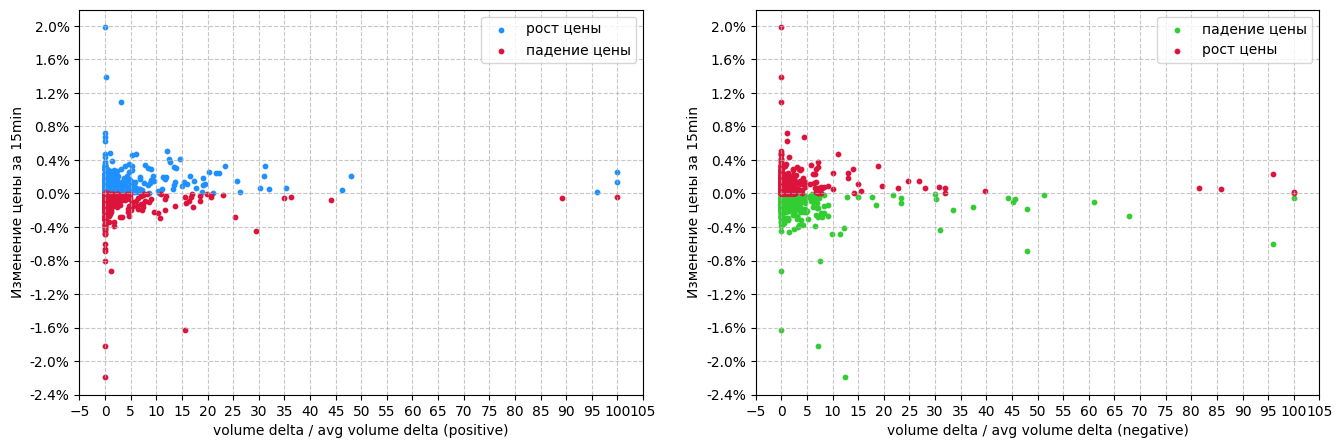

In [ ]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter


indicators_df, ratios = vol_del_conditions(indicators_df, 10, 25)

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5)
)

#при входе в лонг по сигналу с большой положительной дельтой увеличение цены - хорошо, уменьшение - плохо
pos_good_case = ratios['delta_price'] >= 0
pos_bad_case = ratios['delta_price'] < 0

#для шорта наоборот
neg_good_case = pos_bad_case
neg_bad_case = pos_good_case

axes[0].scatter(ratios[pos_good_case]['ratio_pos'], ratios[pos_good_case]['persent_del_price'], color = 'dodgerblue', s=10, label='рост цены')
axes[0].scatter(ratios[pos_bad_case]['ratio_pos'], ratios[pos_bad_case]['persent_del_price'], color = 'crimson', s=10, label='падение цены')
axes[0].legend(loc='upper right')

axes[1].scatter(ratios[neg_good_case]['ratio_neg'], ratios[neg_good_case]['persent_del_price'], color = 'limegreen', s=10, label='падение цены')
axes[1].scatter(ratios[neg_bad_case]['ratio_neg'], ratios[neg_bad_case]['persent_del_price'], color = 'crimson', s=10, label='рост цены')
axes[1].legend(loc='upper right')

axes[0].set_xlabel('volume delta / avg volume delta (positive)')

axes[1].set_xlabel('volume delta / avg volume delta (negative)')

for ax in axes:
    # ось y
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

    # ось х
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

получаем графики где визуально можем определить коэффицент отношения выше которого "хороших" случаев заметно больше чем "плохих", записываем эти значения в переменную threshold

вход в позиции

In [ ]:
def create_opens(indicators_df):

    open_pos_long = (
        indicators_df['vol_open_long']
    )

    open_pos_short = (
        indicators_df['vol_open_short']
    )

    #открытие и закрытие позиций
    longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
    shorts_open = indicators_df.index[ open_pos_short.fillna(False) ].unique()

    return longs_open, shorts_open

расчет TP/SL

In [ ]:
#параметры стратегии
RISK_REWARD_RATIO = 1.8
RISK_PERCENT = 1 
N_TICKS_SL = 15
VOLATILITY_WINDOW = '24h'
COEFFICENT = 2

def calculate_atr(VOLATILITY_WINDOW, df):
    df = df.set_index('recv_time')

    df['price_diff'] = df['price'].diff().abs()
    df['volatility'] = df['price_diff'].rolling(VOLATILITY_WINDOW).mean().bfill()

    df = df.reset_index()

    ticks = df.set_index('recv_time')['price']
    ticks = ticks[~ticks.index.duplicated(keep='first')]

    #волатильность
    vol_series = df.set_index('recv_time')['volatility']
    vol_series = vol_series[~vol_series.index.duplicated(keep='first')]

    bars = df.set_index('recv_time').resample('15min').agg(
        high=('price','max'),
        low =('price','min'),
        close=('price','last')
    )
    bars['prev_close'] = bars['close'].shift()
    bars['tr'] = bars.apply(
        lambda r: max(
            r.high - r.low,
            abs(r.high - r.prev_close),
            abs(r.low  - r.prev_close)
        ), axis=1
    )
    #ATR
    bars['ATR'] = bars['tr'].rolling(window=14).mean().bfill()

    return bars, ticks


def get_nearest_tick(ts, ticks):
    pos = ticks.index.get_indexer([ts], method='nearest')[0]
    return pos

#фуекция расчета цены TP/SL и нахождения их временных меток 
def find_exit_point(open_ts, direction, COEFFICENT, RISK_REWARD_RATIO, ticks, bars):
    pos = get_nearest_tick(open_ts, ticks)
    atr = bars.loc[open_ts, 'ATR']

    entry_price = ticks.iloc[pos]

    sl_amount = COEFFICENT * atr
    tp_amount = RISK_REWARD_RATIO * COEFFICENT * atr

    future = ticks.iloc[pos+1:] 

    if direction == 'long':
        sl_price = entry_price - sl_amount
        tp_price = entry_price + tp_amount

        ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
        ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
    else:
        sl_price = entry_price + sl_amount
        tp_price = entry_price - tp_amount

        ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
        ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

    if ts_sl is not None and ts_tp is not None:
        return (min(ts_sl, ts_tp), sl_price)

    return (ts_sl, sl_price) or (ts_tp, sl_price)#возвращает tuple потому что sl_price понадобится позже в расчете размера позиции

# longs_close  = [find_exit_point(ts, 'long')  for ts in longs_open]
# shorts_close = [find_exit_point(ts, 'short') for ts in shorts_open]

соотнесение временных меток с ценами и создания списков трейдов

In [ ]:
def make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks):
    trades = []

    #соотносим время/цену открытия и закрытия и добавляем в список trades[]
    for open_ts, close_ts in zip(longs_open, longs_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks)
        pos_c = get_nearest_tick(close_ts[0], ticks)

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]
        exit_price  = ticks.iloc[pos_c]

        trades.append({
            'direction':   'long',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      exit_price - entry_price,
            'return':      (exit_price - entry_price) / entry_price,
            'sl_price':    close_ts[1]
        })

    #то же самое для шортов
    for open_ts, close_ts in zip(shorts_open, shorts_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks)
        pos_c = get_nearest_tick(close_ts[0], ticks)

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]
        exit_price  = ticks.iloc[pos_c]

        trades.append({
            'direction':   'short',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      entry_price - exit_price,
            'return':      (entry_price - exit_price) / entry_price,
            'sl_price':    close_ts[1]
    })
    
    return trades

расчет доходности стратегии

In [ ]:
def equity_calc(trades):
    price_ser    = df.set_index('recv_time')['price']
    times  = [trades[0]['entry_time'] if trades else df['recv_time'].iloc[0]]
    DEPOSIT = 10_000
    RISK_PERCENT = 0.01   # 1%
    FEE          = 0.00075  # комиссия bybit

    equity = [DEPOSIT]

    for tr in trades:
        entry_price = tr['entry_price']
        sl_price    = tr['sl_price'] 
        exit_price  = tr['exit_price']
        direction   = tr['direction']

        # долларовый риск
        risk_usd = equity[-1] * RISK_PERCENT

        #расстояние до SL
        stop_distance = abs(entry_price - sl_price)
        if stop_distance == 0:
            # защита от деления на ноль
            position_size = 0
        else:
            position_size = risk_usd / stop_distance

        #PnL, в контрактах умножаем на разницу цен
        if direction == 'long':
            pnl = position_size * (exit_price - entry_price)
        else:  # short
            pnl = position_size * (entry_price - exit_price)

        #комиссия на открытие+закрытие
        notional_entry = position_size * entry_price
        notional_exit  = position_size * exit_price
        commission = (notional_entry + notional_exit) * FEE

        net_pnl = pnl - commission

        # записываем новое equity
        equity.append(equity[-1] + net_pnl)

        times.append(tr['exit_time'])

    #расчёт buy&hold
    bh_price = price_ser
    bh_equity = DEPOSIT * (bh_price / bh_price.iloc[0])

    return equity, bh_equity, times



грид серч (очень долгий)

In [ ]:
# vol_window = ['12h', '24h']
# coefficent = np.linspace(1.0, 4.0, num=10, endpoint=True)
# RRR = np.linspace(1.0, 4.0, num=10, endpoint=True)
# thresholds_long = np.linspace(10.0, 30.0, num=10, endpoint=True)
# thresholds_short = np.linspace(15.0, 35.0, num=10, endpoint=True)

# strat_returns = {
#         'equity': [],
#         'RRR': [],
#         'coefficent': [],
#         'window': [],
#         'threshold_long': [],
#         'threshold_short': [],
# }

# precomputed_atr = {}
# for window in vol_window:
#     bars, ticks = calculate_atr(window, df)
#     precomputed_atr[window] = (bars, ticks)

# for window in vol_window:
#     for coef in coefficent:
#         for rrr in RRR:
#             for threshold_long in thresholds_long:
#                 for threshold_short in thresholds_short:
                    
#                     indicators_df_, ratios = vol_del_conditions(indicators_df, threshold_long, threshold_short)
#                     longs_open, shorts_open = create_opens(indicators_df_)
#                     bars, ticks = precomputed_atr[window]

#                     longs_close  = [find_exit_point(ts, 'long', coef, rrr, ticks, bars)  for ts in longs_open]
#                     shorts_close = [find_exit_point(ts, 'short', coef, rrr, ticks, bars) for ts in shorts_open]

#                     trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks)

#                     equity, bh_equity, times =  equity_calc(trades)

#                     strat_returns['equity'].append((equity[-1]-equity[0])/100)
#                     strat_returns['RRR'].append(rrr)
#                     strat_returns['coefficent'].append(coef)
#                     strat_returns['window'].append(window)
#                     strat_returns['threshold_long'].append(threshold_long)
#                     strat_returns['threshold_short'].append(threshold_short)

# max_eq    = max(strat_returns['equity'])
# max_index = strat_returns['equity'].index(max_eq)
# print(
#     f"Максимальный доход: {max_eq:.5f}%\n"
#     f"RRR: {strat_returns['RRR'][max_index]}\n"
#     f"window: {strat_returns['window'][max_index]}\n"
#     f"coefficent: {strat_returns['coefficent'][max_index]}"
#     f"сколько бабок в чистом виде: {max_eq*100} "
#     f'threshold_long: {strat_returns['threshold_long'][max_index]}'
#     f'threshold_short: {strat_returns['threshold_short'][max_index]}'
# )

вызов функций с лучшими параметрами

In [ ]:
COEFFICENT = 1.6666666666666665
RRR = 2
WINDOW = '12h'

indicators_df_, ratios = vol_del_conditions(indicators_df, 12.222222222222221, 30.555555555555557)
longs_open, shorts_open = create_opens(indicators_df_)
bars, ticks = calculate_atr(WINDOW, df)

longs_close  = [find_exit_point(ts, 'long', COEFFICENT, RRR, ticks, bars)  for ts in longs_open]
shorts_close = [find_exit_point(ts, 'short', COEFFICENT, RRR, ticks, bars) for ts in shorts_open]

trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks)

equity, bh_equity, times =  equity_calc(trades)


отрисовка точек входа на цене

C:\Users\382he\AppData\Local\Temp\ipykernel_32488\773374501.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='best')
C:\Users\382he\AppData\Local\Temp\ipykernel_32488\773374501.py:88: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.15)


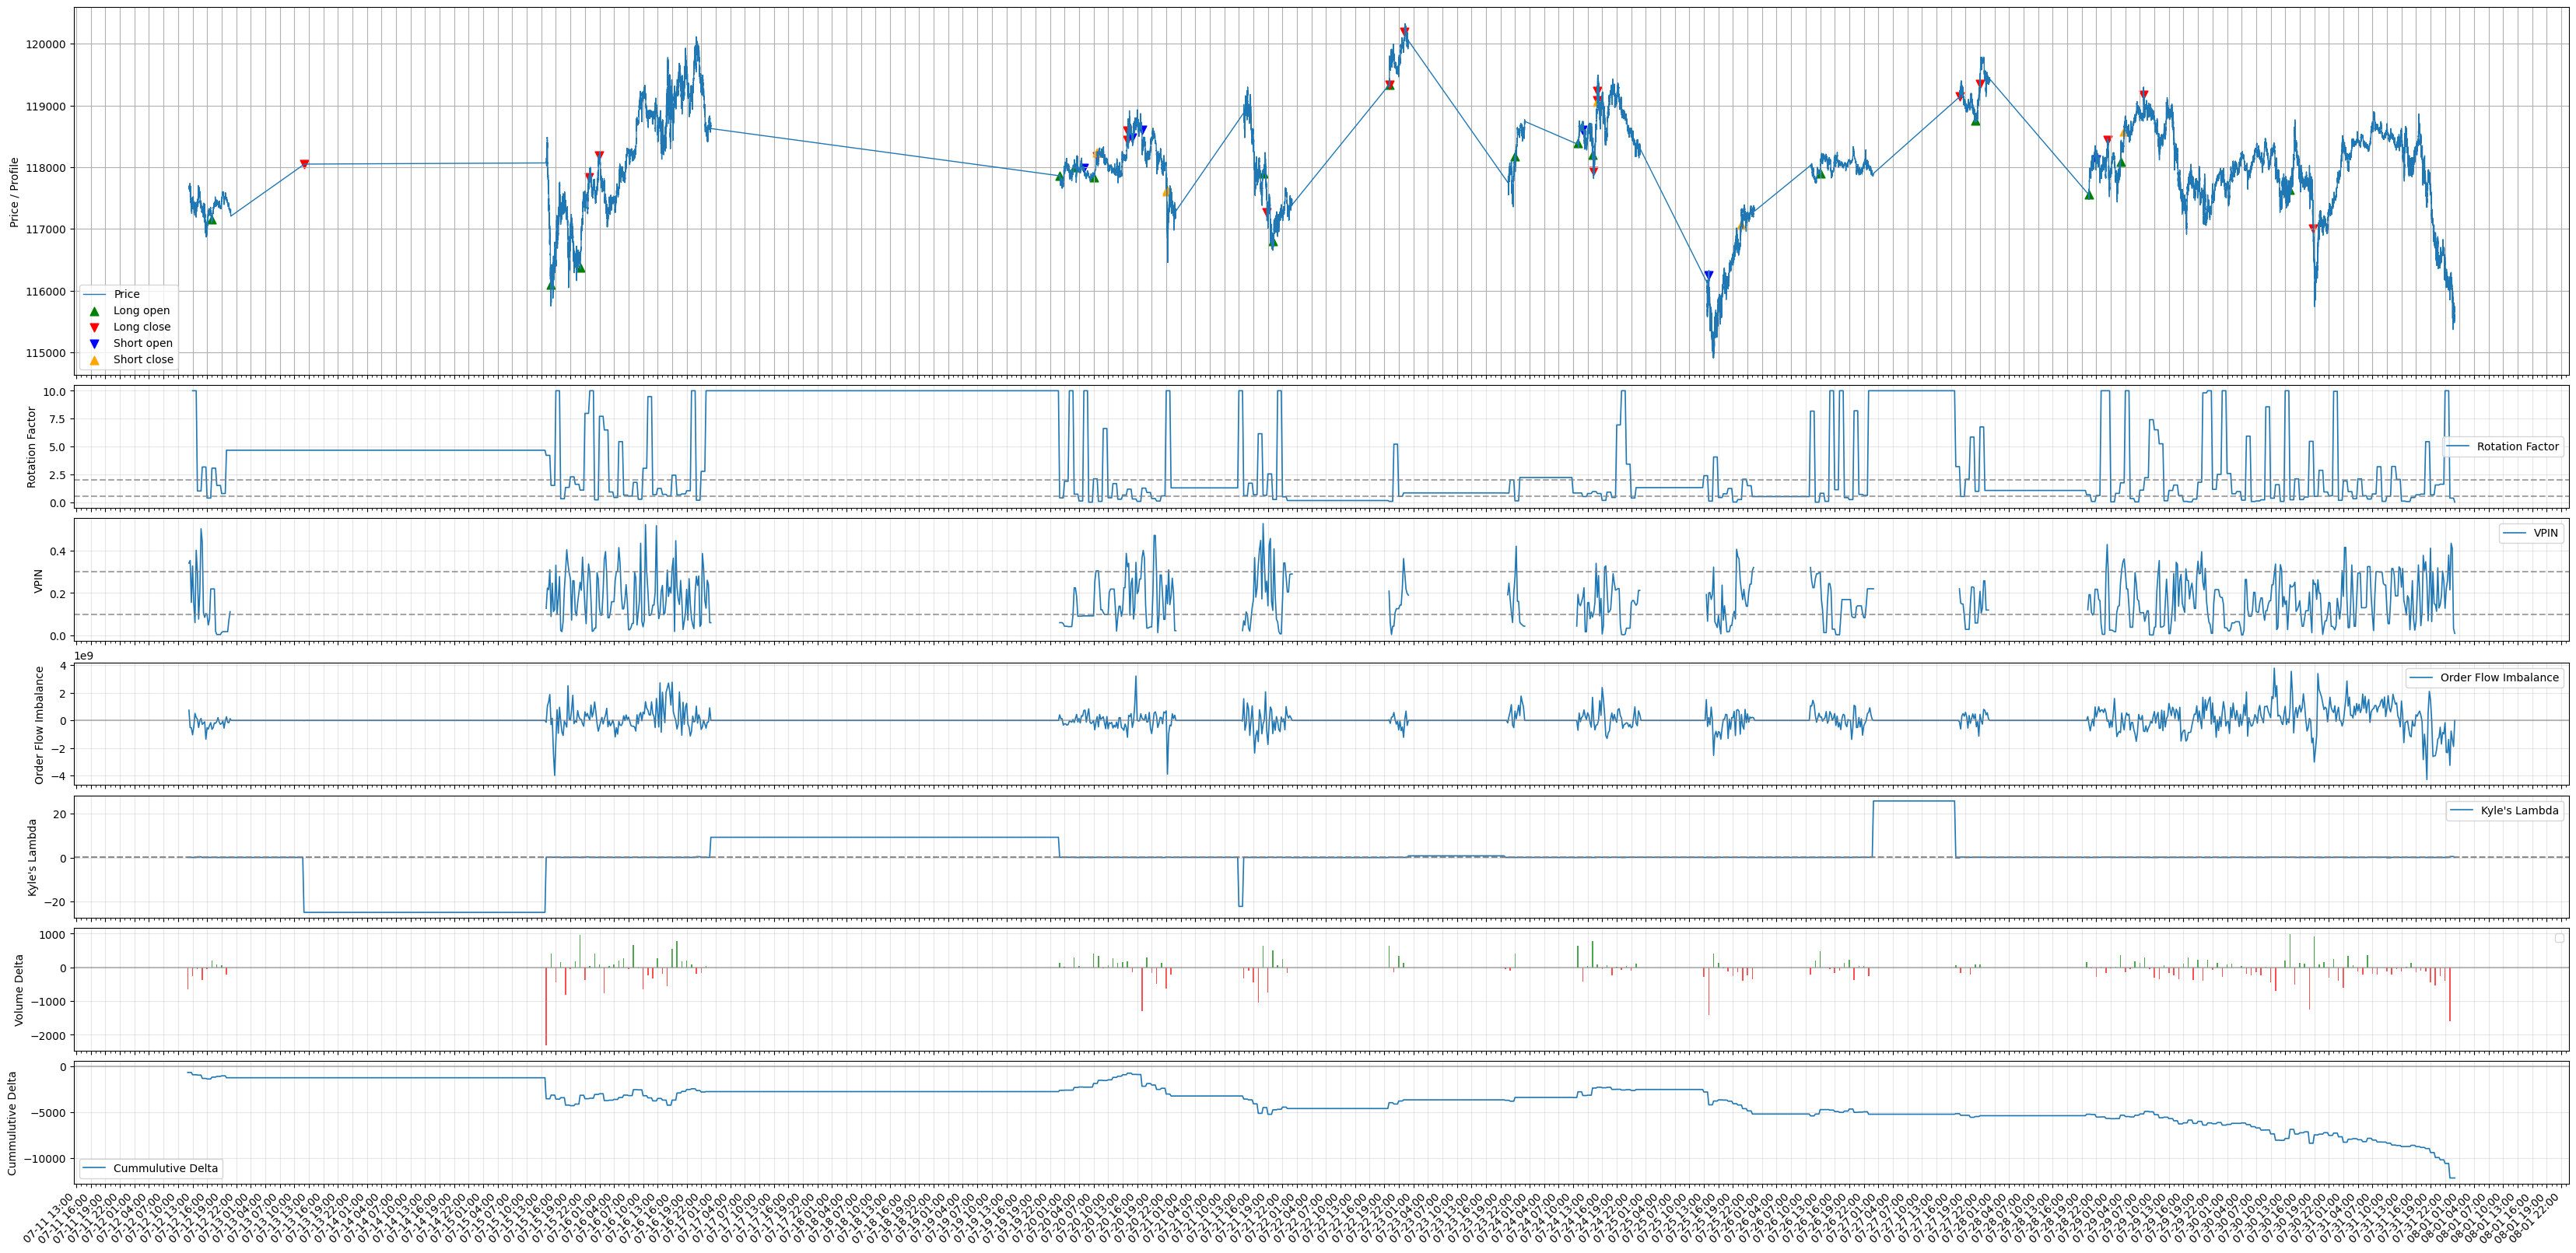

In [ ]:
fig, axes = plt.subplots(
    7, 1,
    figsize=(33, 16),
    constrained_layout=True,
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1]}
)
ax0 = axes[0]

# цена
ax0.plot(df['recv_time'], df['price'], label='Price', linewidth=1)
# ax0.plot(indicators_df.index, indicators_df['VAH'], label='VAH')
# ax0.plot(indicators_df.index, indicators_df['VAL'], label='VAL')

# 1)разделяем trades на два списка
trades_long  = [t for t in trades if t['direction'] == 'long']
trades_short = [t for t in trades if t['direction'] == 'short']

# извлекаем отдельно entry/exit времена и цены для каждого направления
long_open_times  = [t['entry_time']  for t in trades_long]
long_open_prices = [t['entry_price'] for t in trades_long]
long_close_times  = [t['exit_time']  for t in trades_long]
long_close_prices = [t['exit_price'] for t in trades_long]

short_open_times  = [t['entry_time']   for t in trades_short]
short_open_prices = [t['entry_price']  for t in trades_short]
short_close_times  = [t['exit_time']   for t in trades_short]
short_close_prices = [t['exit_price']  for t in trades_short]

#наносим на график

ax0.scatter(long_open_times,  long_open_prices,  marker='^', color='g', s=60, label='Long open')
ax0.scatter(long_close_times, long_close_prices, marker='v', color='r', s=60, label='Long close')

ax0.scatter(short_open_times,  short_open_prices,  marker='v', color='b',      s=60, label='Short open')
ax0.scatter(short_close_times, short_close_prices, marker='^', color='orange', s=60, label='Short close')

ax0.set_ylabel("Price / Profile")
ax0.legend(loc='lower left')
ax0.grid(True)

indicators = ['RF','VPIN','OFI','Kyle_Lambda','volume_delta', 'cum_delta']
titles = ['Rotation Factor', 'VPIN', 'Order Flow Imbalance', "Kyle's Lambda", 'Volume Delta', 'Cummulutive Delta']

for i, indicator in enumerate(indicators, start=1):
    if indicator == 'volume_delta':
        colors = np.where(indicators_df[indicator] >= 0, 'green', 'red')
        axes[i].bar(indicators_df.index, indicators_df[indicator], color=colors, alpha=0.7, width=0.01)
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    else:
        axes[i].plot(indicators_df.index, indicators_df[indicator], label=titles[i-1], linewidth=1.2)
    
    #ключевые уровни для каждого индикатора
    if indicator == 'RF':
        axes[i].axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(2.0, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'VPIN':
        axes[i].axhline(0.1, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.3, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'Kyle_Lambda':
        axes[i].axhline(0.05, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.2, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'OFI':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    elif indicator == 'cum_delta':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    
    axes[i].set_ylabel(titles[i-1])
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='best')

for ax in axes:
    #локатор дат каждые 3 часа
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    
    #формат дата время
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    
    #дополнительные минорные деления (каждый час)
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    
    #поворот меток
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.subplots_adjust(bottom=0.15)
# plt.tight_layout()
plt.show()

отрисовка дохода

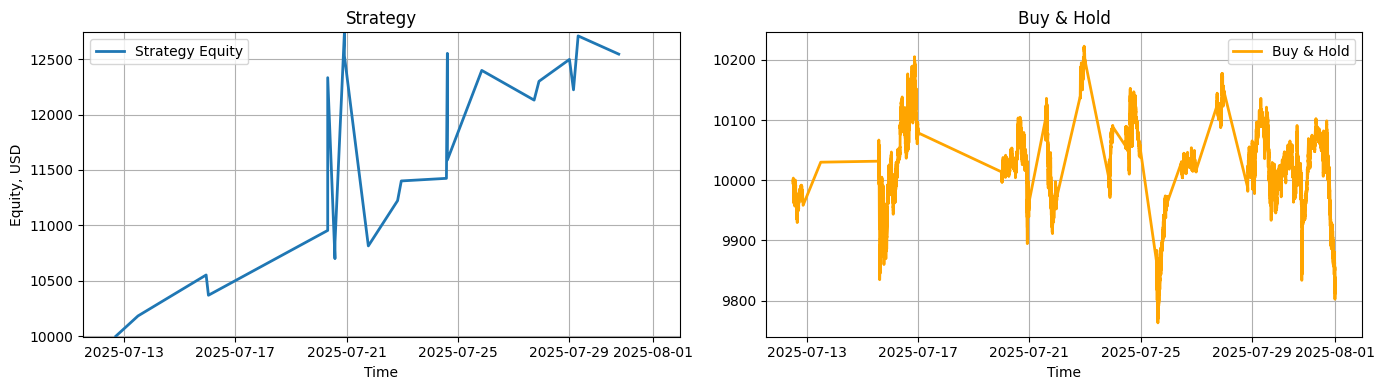

Strategy returns:
22.23573 %, Balance: 12223.57304
Buy&Hold returns:
-1.71857 %, Balance: 9828.14319


C:\Users\382he\AppData\Local\Temp\ipykernel_32488\3048075414.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.5f} %, Balance: {bh_equity[-1]:.5f}')


In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4),sharex=True, sharey=False)

# Стратегия
pts = sorted(zip(times, equity), key=lambda x: x[0])
times_sorted, equity_sorted = zip(*pts)

ax0.plot(times_sorted, equity_sorted, label='Strategy Equity', linewidth=2)
ax0.set_title("Strategy")
ax0.set_xlabel("Time")
ax0.set_ylabel("Equity, USD")
ax0.legend()
ax0.grid(True)
# Сузим диапазон Y, чтобы мелкие изменения было видно:
y_min = min(equity)*0.9995
y_max = max(equity)*1.0005
ax0.set_ylim(y_min, y_max)

# Buy & Hold
ax1.plot(bh_equity.index, bh_equity.values, 
         label='Buy & Hold', color='orange', linewidth=2)
ax1.set_title("Buy & Hold")
ax1.set_xlabel("Time")
ax1.legend()
ax1.grid(True)


plt.tight_layout()
plt.show()

print(f'Strategy returns:\n{(equity[-1]-equity[0])/100:.5f} %, Balance: {equity[-1]:.5f}')
print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.5f} %, Balance: {bh_equity[-1]:.5f}')